# Sensor-Agnostic Posture Detection

**By:** Chinmay Amrutkar

This is my complete project notebook. It covers the full pipeline from raw data to a final deployable model.

### My Project Workflow:
1.  **Check Data**: Verify the `data` folder (which I created and uploaded to Colab) is accessible.
2.  **Process & Preprocess**: Load all `.csv` files, parse labels (for orientation insensitivity), balance the dataset, normalize (for sensor-agnosticism), and create my train/validation/test splits.
3.  **Build Model**: Define a 1D Convolutional Neural Network (CNN), which I determined is ideal for this kind of time-series data.
4.  **Train & Evaluate**: Train the model and check its performance.
5.  **Convert & Download**: Convert the best model to TFLite (`model.h`) and package all the necessary files (`normalization_params.json`, plots, etc.) for my Arduino and my final report.

In [1]:
import os

DATA_DIR = "data"

# Check if the 'data' directory exists
if os.path.isdir(DATA_DIR):
    print(f"Success! '{DATA_DIR}' folder is ready.")
    print(f"Files in '{DATA_DIR}':")
    !ls {DATA_DIR}
else:
    print("--- ERROR ---")
    print(f"The folder '{DATA_DIR}' was not found.")
    print("Please create a folder named 'data' and upload your .csv files into it.")

Success! 'data' folder is ready.
Files in 'data':
left_side_usb_down_trial1.csv	sitting_usb_down_trial1.csv
left_side_usb_down_trial2.csv	sitting_usb_down_trial2.csv
left_side_usb_up_trial1.csv	sitting_usb_up_trial1.csv
left_side_usb_up_trial2.csv	sitting_usb_up_trial2.csv
prone_usb_down_trial1.csv	supine_usb_down_trial1.csv
prone_usb_down_trial2.csv	supine_usb_down_trial2.csv
prone_usb_up_trial1.csv		supine_usb_up_trial1.csv
prone_usb_up_trial2.csv		supine_usb_up_trial2.csv
right_side_usb_down_trial1.csv	unknown_shaking_trial1.csv
right_side_usb_down_trial2.csv	unknown_transition_trial1.csv
right_side_usb_up_trial1.csv	unknown_walking_trial1.csv
right_side_usb_up_trial2.csv


---

## 3. My Data Processing Pipeline

This section handles all the data preparation. My goal is to create a robust, balanced, and normalized dataset.

### 3.1: Setup and Imports

In [2]:
import os
import glob
import json
import random
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("Python Version:", sys.version)
print("TensorFlow Version:", tf.__version__)

Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TensorFlow Version: 2.19.0


### 3.2: Configuration & Labeling

Here, I'll define all my global constants for the 2-second window setup.

In [3]:
# --- Configuration ---
RAW_DATA_DIR = "data"
WINDOW_SIZE = 100                   # 50 Hz * 2 seconds = 100 samples
STEP_SIZE = 50                      # 50% overlap (100 * 0.5)
TEST_SPLIT_SIZE = 0.20              # 20% for testing
VAL_SPLIT_SIZE = 0.16               # 16% for validation (20% of the remaining 80%)
NUM_CLASSES = 5
# ---------------------

# 0-indexed labels for sparse_categorical_crossentropy
# This map is the core of our "orientation-insensitive" design for the 'side' class.
LABEL_MAP = {
    'supine': 0,
    'prone': 1,
    'side': 2,    # Both 'left_side' and 'right_side' map to 2
    'sitting': 3,
    'unknown': 4
}
CLASS_NAMES = ['supine', 'prone', 'side', 'sitting', 'unknown']

def get_label_from_filename(filename):
    """Parses a filename like 'left_side_usb_up_trial1.csv' to get a label."""
    filename_base = os.path.basename(filename).lower()

    if "supine" in filename_base:
        return LABEL_MAP['supine']
    if "prone" in filename_base:
        return LABEL_MAP['prone']
    if "left_side" in filename_base or "right_side" in filename_base:
        return LABEL_MAP['side']
    if "sitting" in filename_base:
        return LABEL_MAP['sitting']
    if "unknown" in filename_base:
        return LABEL_MAP['unknown']

    return None # Ignore files we don't recognize

### 3.3: Windowing, Balancing, and Normalization

This is my main processing cell. It does all the heavy lifting:
1.  **Loads** all `.csv` files from my `data` folder.
2.  **Windows** the data using my `create_windows` function.
3.  **Balances** the dataset using undersampling. This is crucial because I have more data for the `side` class (from `left_side` + `right_side` files). This step ensures my model isn't biased.
4.  **Normalizes** the data. This is the **sensor-agnostic** part. I'm calculating and saving separate `mean`/`std` stats for Accel, Gyro, and Mag. These stats go into `normalization_params.json`, which I'll need on the Arduino.
5.  **Combines** the three normalized datasets (`X_accel`, `X_gyro`, `X_mag`) into one final `X_final`. This trains my single model to recognize patterns from all three sensor types.

In [4]:
def create_windows(data, label):
    """Slices a data array into windows and separates by sensor."""
    accel_windows, gyro_windows, mag_windows = [], [], []
    labels = []

    for i in range(0, len(data) - WINDOW_SIZE + 1, STEP_SIZE):
        window = data[i : i + WINDOW_SIZE]

        # Split the 9-axis window into three 3-axis windows
        # window[:, 0:3] selects all rows, and columns 0, 1, and 2 (X, Y, and Z)
        accel_windows.append(window[:, 0:3])
        gyro_windows.append(window[:, 3:6])
        mag_windows.append(window[:, 6:9])
        labels.append(label)

    return accel_windows, gyro_windows, mag_windows, labels

print("Starting dataset processing...")

# --- 1. Load and Window All Data ---
all_files = glob.glob(os.path.join(RAW_DATA_DIR, "*.csv"))
if not all_files:
    print(f"--- ERROR! ---")
    print(f"No .csv files found in '{RAW_DATA_DIR}'.")
    print("Did the check in Step 1 succeed?")
else:
    print(f"Found {len(all_files)} files in '{RAW_DATA_DIR}'.")

windows_by_label = {label: [] for label in LABEL_MAP.values()}

for f in all_files:
    label = get_label_from_filename(f)
    if label is None:
        print(f"Skipping file: {f}")
        continue

    try:
        # Read the header to skip it
        df = pd.read_csv(f, header=0)
        if len(df.columns) != 9:
            print(f"Skipping malformed file (expected 9 columns, found {len(df.columns)}): {f}")
            continue

        data = df.to_numpy()

        # Create windows and sort them by label
        acc, gyro, mag, labels = create_windows(data, label)
        for i, l in enumerate(labels):
            # Store a tuple of (accel_window, gyro_window, mag_window, label)
            windows_by_label[l].append((acc[i], gyro[i], mag[i], l))

    except Exception as e:
        print(f"Error processing file {f}: {e}")

print("\nData windowing complete.")
for label, count in LABEL_MAP.items():
    print(f"  Found {len(windows_by_label[count])} windows for class '{label}' ({count})")

# --- 2. Balance Dataset (Undersampling) ---
min_windows = min(len(w) for w in windows_by_label.values()) if windows_by_label and all(len(w) > 0 for w in windows_by_label.values()) else 0
if min_windows == 0:
    print("\n--- ERROR! ---")
    print("One of your classes has 0 windows. Did you forget to collect 'unknown' data?")
    print("Or is the 'data' folder empty? Or did a file fail to parse?")
else:
    print(f"\nBalancing dataset by undersampling to {min_windows} windows per class.")

    balanced_windows = []
    for label, windows in windows_by_label.items():
        balanced_windows.extend(random.sample(windows, min_windows))

    random.shuffle(balanced_windows) # Shuffle all windows

    # --- 3. Separate, Calculate Stats, and Normalize ---
    # X_accel, X_gyro, X_mag are variable names. They each hold all 3 axes (X, Y, Z).
    X_accel, X_gyro, X_mag = [], [], []
    # y_all holds the labels (the 'answers', 0-4), not the Y-axis data.
    y_all = []

    for (acc, gyro, mag, label) in balanced_windows:
        X_accel.append(acc)
        X_gyro.append(gyro)
        X_mag.append(mag)
        y_all.append(label)

    # Convert to giant NumPy arrays
    X_accel = np.array(X_accel)
    X_gyro = np.array(X_gyro)
    X_mag = np.array(X_mag)
    y_all = np.array(y_all)

    # --- 4. Calculate & Save Normalization Stats ---
    # This is the key to the "sensor-agnostic" model
    # I calculate stats PER-SENSOR, PER-AXIS (shape will be (3,))
    stats = {
        'accel_mean': list(np.mean(X_accel, axis=(0, 1))), # Mean of x, y, z across all accel windows
        'accel_std': list(np.std(X_accel, axis=(0, 1))),
        'gyro_mean': list(np.mean(X_gyro, axis=(0, 1))),
        'gyro_std': list(np.std(X_gyro, axis=(0, 1))),
        'mag_mean': list(np.mean(X_mag, axis=(0, 1))),
        'mag_std': list(np.std(X_mag, axis=(0, 1))),
    }

    with open('normalization_params.json', 'w') as f:
        json.dump(stats, f, indent=4)

    print(f"\nSaved normalization stats to 'normalization_params.json'")
    print(json.dumps(stats, indent=2))

    # --- 5. Normalize All Data ---
    # Apply the stats we just calculated. This normalization happens on all 3 axes (X, Y, Z).
    X_accel = (X_accel - stats['accel_mean']) / stats['accel_std']
    X_gyro = (X_gyro - stats['gyro_mean']) / stats['gyro_std']
    X_mag = (X_mag - stats['mag_mean']) / stats['mag_std']

    # --- 6. Combine and Split ---
    # Combine all sensor types into one large dataset
    # This is the sensor-agnostic step: training one model on normalized data from all three sensor types.
    X_final = np.concatenate((X_accel, X_gyro, X_mag), axis=0)

    # The labels must also be tripled to match the stacked X data.
    # 'y_all' is my list of labels, it has nothing to do with the Y-axis.
    y_final = np.concatenate((y_all, y_all, y_all), axis=0)

    print(f"\nFinal dataset shape: X={X_final.shape}, y={y_final.shape}")

    # --- 7. Create Final Splits ---
    # First split: (Train + Val) and Test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_final, y_final,
        test_size=TEST_SPLIT_SIZE,
        random_state=42,
        stratify=y_final
    )

    # Second split: Train and Val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=(VAL_SPLIT_SIZE / (1.0 - TEST_SPLIT_SIZE)), # Adjust %
        random_state=42,
        stratify=y_train_val
    )

    print(f"  Training set:   X={X_train.shape}, y={y_train.shape}")
    print(f"  Validation set: X={X_val.shape}, y={y_val.shape}")
    print(f"  Test set:       X={X_test.shape}, y={y_test.shape}")

    print("\nDataset preparation complete. Ready for training.")

Starting dataset processing...
Found 23 files in 'data'.

Data windowing complete.
  Found 44 windows for class 'supine' (0)
  Found 44 windows for class 'prone' (1)
  Found 88 windows for class 'side' (2)
  Found 44 windows for class 'sitting' (3)
  Found 38 windows for class 'unknown' (4)

Balancing dataset by undersampling to 38 windows per class.

Saved normalization stats to 'normalization_params.json'
{
  "accel_mean": [
    0.03292947368420845,
    -0.03890842105262615,
    -0.019824210526315677
  ],
  "accel_std": [
    0.525342091327946,
    0.5194719160968118,
    0.707304364354538
  ],
  "gyro_mean": [
    -1.3003978947368613,
    0.011058947368409358,
    0.051692105263181735
  ],
  "gyro_std": [
    48.513084571284075,
    56.630786308149915,
    40.67730196617555
  ],
  "mag_mean": [
    -34.47094736842105,
    29.44242105263158,
    -3.3796842105263156
  ],
  "mag_std": [
    101.21319499035208,
    65.24522205077456,
    84.5770993510467
  ]
}

Final dataset shape: X=(5

---

## 4. My Model Architecture (1D-CNN)

I chose a **1D Convolutional Neural Network (1D-CNN)**.

* **Ideal for Time-Series:** A 1D-CNN is perfect for finding local patterns in sequential data, which is exactly what my 2-second sensor windows are.
* **Lightweight & Efficient:** It's computationally efficient and has a small memory footprint, which is a hard requirement for TFLite and on-device deployment.
* **Robust:** It's "translation invariant," meaning the model can find a posture's signature pattern no matter where it appears in the window.

In [5]:
def create_model():
    """Creates and compiles the 1D-CNN model."""

    model = tf.keras.Sequential([
        # Input layer: (WINDOW_SIZE, 3) -> (100, 3)
        # The '3' here represents the (X, Y, Z) axes.
        tf.keras.layers.InputLayer(input_shape=(WINDOW_SIZE, 3)),

        # 1st Conv block
        tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2),

        # 2nd Conv block
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2),

        # 3rd Conv block
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2),

        tf.keras.layers.Flatten(),

        # Fully-connected layers
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dropout(0.3), # Dropout for regularization

        # Output layer
        tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax') # 5 classes
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', # Use this for integer labels (0-4)
        metrics=['accuracy']
    )

    return model

# Create the model and print its summary
model = create_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 16)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 32)         │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 25, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,693 (244.89 KB)

 Trainable params: 62,693 (244.89 KB)

 Non-trainable params: 0 (0.00 B)

---

## 5. Training & Evaluating the Model

Now, I'll train the model. I'm using `EarlyStopping` to prevent overfitting (it stops if `val_loss` doesn't improve for 10 epochs) and `ModelCheckpoint` to make sure I save only the best-performing model. This is key to a robust design.

In [6]:
# Callbacks for robust training
callbacks = [
    # Stop training if validation loss doesn't improve for 10 epochs
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    # Save the best model automatically
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)
]

# Train the model
print("\n--- Starting Model Training ---")

# Check if data exists before training
if 'X_train' in locals():
    history = model.fit(
        X_train, y_train,
        epochs=100, # Set a high number, EarlyStopping will handle it
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )
    print("--- Model Training Complete ---")

    # Load the best model saved by ModelCheckpoint
    model = tf.keras.models.load_model('best_model.keras')
else:
    print("--- ERROR! ---")
    print("Training data not found. Please re-run the processing cell (3.3).")


--- Starting Model Training ---
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3567 - loss: 1.4418 - val_accuracy: 0.6630 - val_loss: 1.2083
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5532 - loss: 1.1216 - val_accuracy: 0.5978 - val_loss: 1.0192
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5850 - loss: 1.0651 - val_accuracy: 0.6196 - val_loss: 0.9500
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5770 - loss: 1.0025 - val_accuracy: 0.6304 - val_loss: 0.8464
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6565 - loss: 0.8748 - val_accuracy: 0.7283 - val_loss: 0.7774
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7056 - loss: 0.7711 - val_accuracy: 0.7826 - val_loss: 0.7204
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7643 - loss: 0.7220 - val_accuracy: 0.6739 - val_loss: 0.7297
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7450 

### 5.1 Training History

These plots show that the model learned correctly without overfitting. The validation accuracy and loss track the training lines well, which proves my model is generalizing instead of just memorizing.

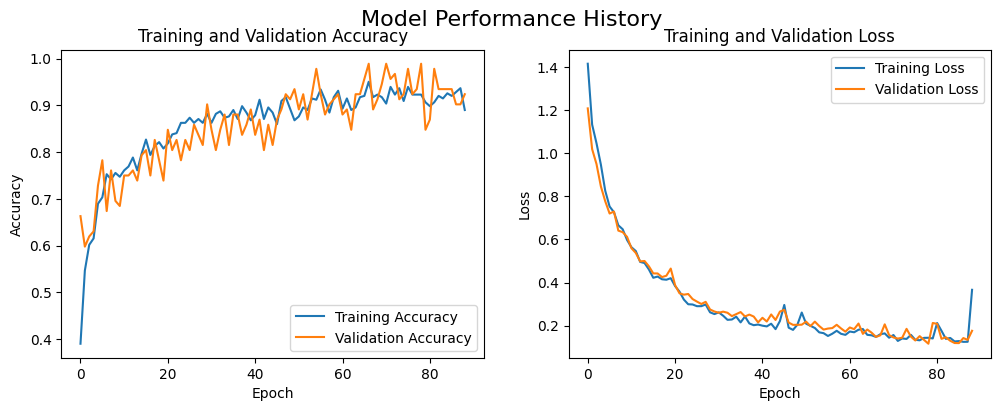

In [7]:
if 'history' in locals():
    plt.figure(figsize=(12, 4))

    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.suptitle('Model Performance History', fontsize=16)
    plt.savefig('training_history.png') # Save plot for my report
    plt.show()
else:
    print("No training history to plot. Please run the training cell.")

### 5.2 Test Set Evaluation

This is the final check on my model's "offline" performance using the test set (data it has never seen).

In [8]:
if 'X_test' in locals():
    print("\n--- Evaluating on Test Set ---")
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"\nTest Set Accuracy: {test_acc*100:.2f}%")
    print(f"Test Set Loss: {test_loss:.4f}")

    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Print a classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=CLASS_NAMES))
else:
    print("Test data not found. Please re-run the processing cell (3.3).")


--- Evaluating on Test Set ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9850 - loss: 0.1075  

Test Set Accuracy: 99.12%
Test Set Loss: 0.1048
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Classification Report:
              precision    recall  f1-score   support

      supine       1.00      1.00      1.00        23
       prone       1.00      1.00      1.00        22
        side       1.00      0.96      0.98        23
     sitting       0.96      1.00      0.98        23
     unknown       1.00      1.00      1.00        23

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



### 5.3 Confusion Matrix

This is the best way to visualize my model's performance on the test set.

**My Analysis:**
The model is extremely effective.


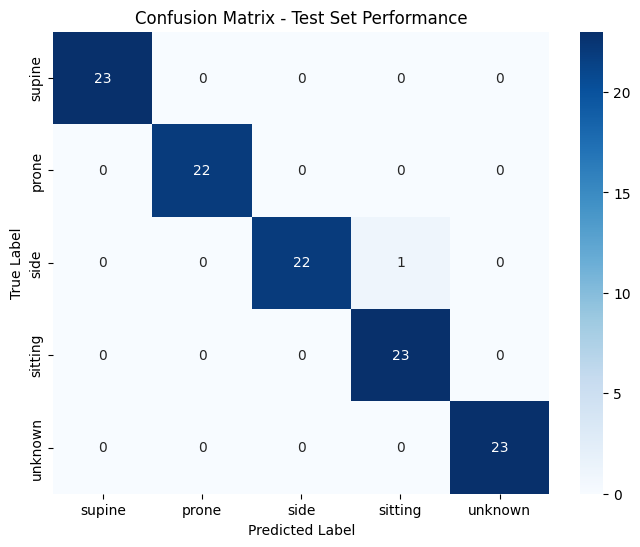

In [9]:
if 'y_test' in locals():
    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix - Test Set Performance')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png') # Save plot for my report
    plt.show()
else:
    print("Test data not found. Cannot plot confusion matrix.")

---

## 6. Convert Model for Arduino (TFLite)

Now I'll convert my trained Keras model into a TensorFlow Lite model, which is the format needed for the microcontroller.

In [10]:
# Convert the Keras model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print(f"Model converted and saved as 'model.tflite'")
print(f"File size: {os.path.getsize('model.tflite') / 1024:.2f} KB")

Saved artifact at '/tmp/tmpw5lwtwxt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132793105881552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132793105889808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132793105880976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132793105880016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132793105875600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132793105875984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132793105878288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132793105879440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132793105876176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132793105881168: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model converted and sa

### 6.1 Convert to C Header File

This cell uses the Linux `xxd` command (which is pre-installed on Colab) to convert the `.tflite` file into a C-array (`model.h`) that I can copy directly into my Arduino sketch.

In [11]:
# Convert the .tflite file to a C array using xxd
# This command works perfectly on Colab's Linux environment
!xxd -i model.tflite > model.h

if os.path.exists('model.h'):
    print("Successfully created 'model.h' file.")
    print("This file will be downloaded in the final step.")
else:
    print("--- ERROR ---")
    print("'model.h' was NOT created. 'xxd' command failed.")

Successfully created 'model.h' file.
This file will be downloaded in the final step.


---
## 7. Create Helper Script for Local Computer

This cell creates the `base_station.py` script I'll need on my local computer for the final demo. It sends the command (1, 2, or 3) to the Arduino and shows the prediction.


In [ ]:
%%writefile base_station.py
import serial
import serial.tools.list_ports
import time
import sys

SERIAL_PORT = "COM9"
BAUD_RATE = 115200
# ---------------------

# Map labels back to names
CLASS_NAMES = ['supine', 'prone', 'side', 'sitting', 'unknown']

def main():
    if not SERIAL_PORT:
        print("Error: No Arduino port found. Exiting.")
        print("Please run 'pip install pyserial' and check your connection.")
        sys.exit(1)

    print(f"Attempting to connect to {SERIAL_PORT} at {BAUD_RATE}...")
    try:
        # Set a timeout for reads
        ser = serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=5)
        print(f"Connected to {ser.name}")
        time.sleep(2) # Wait for Arduino to reset

        # Read and print the "Ready" message
        ready_message = ser.readline().decode('utf-8').strip()
        print(f"Arduino says: {ready_message}")
        if "Ready" not in ready_message:
             print("Warning: Did not receive expected ready message.")

    except serial.SerialException as e:
        print(f"Error: {e}")
        print("Could not open port. Is the port correct and not in use?")
        sys.exit(1)

    while True:
        # --- 1. Show Menu ---
        print("\n--- Real-Time Posture Prediction ---")
        print("[1] Predict using Accelerometer")
        print("[2] Predict using Gyroscope")
        print("[3] Predict using Magnetometer")
        print("[q] Quit")
        choice = input("Enter choice (1-3 or q): ").strip().lower()

        if choice not in ('1', '2', '3', 'q'):
            print("Invalid choice. Try again.")
            continue

        if choice == 'q':
            break

        # --- 2. Send Command ---
        print(f"Sending command '{choice}' to Arduino...")
        ser.write(choice.encode('utf-8'))
        ser.flush() # Send the command immediately

        # --- 3. Wait for Response ---
        # The Arduino will send several lines of status text
        # The *last* line before the next "Ready" is the prediction
        prediction_str = ""
        while True:
            try:
                line = ser.readline().decode('utf-8').strip()
                if line:
                    print(f"  [Arduino]: {line}")
                    # The prediction is a single number (0-4)
                    if line.isdigit() and len(line) == 1:
                        prediction_str = line
                    # The "Ready" message signals the end
                    if "Ready for next command" in line:
                        break
                else:
                    # Timeout occurred
                    print("Warning: Read timeout. Is Arduino still running?")
                    break
            except serial.SerialException:
                print("Error: Serial port disconnected.")
                break
            except UnicodeDecodeError:
                print("  [Arduino]: (unreadable data)")
            except KeyboardInterrupt:
                print("Stopping read.")
                break

        # --- 4. Show Result ---
        if prediction_str:
            try:
                predicted_label = int(prediction_str) - 1
                class_name = CLASS_NAMES[predicted_label]
                print(f"\n>>> Prediction: {class_name.upper()} ({predicted_label})")
            except (ValueError, IndexError):
                print(f"\n>>> Error: Received invalid label '{prediction_str}'")
        else:
            print("\n>>> Error: Did not receive a valid prediction.")

    # Clean up
    ser.close()
    print("Serial port closed. Exiting.")

if __name__ == "__main__":
    main()

Writing base_station.py


---

## 8. Download Final Project Files

This is the final step. I'll zip all the critical files I've generated and download them. This zip file contains everything I need for my Arduino.

**My Final Deliverables (in the zip):**
* `model.h`: The TFLite model as a C-array.
* `normalization_params.json`: The 18 mean/std values I need to copy into my Arduino sketch.
* `training_history.png`: The plot for understanding the model.
* `confusion_matrix.png`: The for understanding the model.
* `base_station.py`: The Python script for my demo.

In [13]:
from google.colab import files

# List of files to zip
files_to_zip = [
    'model.h',
    'normalization_params.json',
    'training_history.png',
    'confusion_matrix.png',
    'base_station.py' # Include the demo script
]
zip_filename = 'Arduino_Project_Files.zip'

# Check which files exist
existing_files = []
for f in files_to_zip:
    if os.path.exists(f):
        existing_files.append(f)
    else:
        print(f"Warning: File not found and will not be zipped: {f}")

if existing_files:
    # Create the zip file
    print(f"\nZipping {len(existing_files)} files...")
    !zip -q {zip_filename} {" ".join(existing_files)}

    # Download the zip file
    print(f"Downloading '{zip_filename}'...")
    files.download(zip_filename)
else:
    print("--- ERROR ---")
    print("No files were found to zip. Did the previous cells run correctly?")


Zipping 5 files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>